In [55]:
# Mathematical/data cleaning tools
import numpy as np
import pandas as pd
from collections import Counter

#sklearn
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix

#gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import CoherenceModel

#nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
# nltk.download('wordnet')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

## Twitter Data

In [56]:
twitter = pd.read_csv('data/full-corpus.csv')
# twitter2 = pd.read_csv('data/twitter_en.txt', sep='\n')
len(twitter)

5113

In [57]:
twitter.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [58]:
twitter['Sentiment'].unique()

array(['positive', 'negative', 'neutral', 'irrelevant'], dtype=object)

In [59]:
pos_df = twitter[twitter['Sentiment'] == 'positive']
print(len(pos_df))

519


In [60]:
neg_df = twitter[twitter['Sentiment'] == 'negative']
print(len(neg_df))

572


In [61]:
neutral_df = twitter[twitter['Sentiment'] == 'neutral']
print(len(neutral_df))

2333


In [62]:
irr_df = twitter[twitter['Sentiment'] == 'irrelevant']
print(len(irr_df))

1689


In [63]:
twitter.Topic.unique()

array(['apple', 'google', 'microsoft', 'twitter'], dtype=object)

In [64]:
apple_df = twitter[twitter['Topic'] == 'apple']
len(apple_df)

1142

In [65]:
google_df = twitter[twitter['Topic'] == 'google']
len(google_df)

1317

In [66]:
microsoft_df = twitter[twitter['Topic'] == 'microsoft']
len(microsoft_df)

1364

In [67]:
twitter_df = twitter[twitter['Topic'] == 'twitter']
len(twitter_df)

1290

In [136]:
# f = open('src/stop_words/spanish.txt', 'r')
x = [line.rstrip() for line in open('src/stop_words/spanish.txt')]

In [137]:
x = set(x)
x

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

In [104]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text, min_len=0):
    result = []
    stopwords = STOPWORDS.copy()
    stopwords = set(stopwords)
    stopwords.update(["google", 
                      "apple", 
                      "que", 
                      "es", 
                      "rt", 
                      "twitter", 
                      "http", 
                      "microsoft", 
                      "la", 
                      "el", 
                      "en", 
                      "lo", 
                      "use",
                      "app",
                      "like",
                      "los",
                      "get",
                      "ya",
                      "le",
                      "por",
                      
                      "new"])
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in stopwords and len(token) > min_len:
            result.append(lemmatize_stemming(token))
    return result

In [105]:
stemmer = SnowballStemmer('english')
processed_docs = twitter['TweetText'].map(preprocess)

In [106]:
type(processed_docs)

pandas.core.series.Series

In [107]:
processed_docs.head(20)

0                          [swype, iphon, crack, iphon]
1               [add, carrier, support, iphon, announc]
2     [hilari, youtub, video, guy, duet, siri, prett...
3                            [rim, easi, switch, iphon]
4                      [realiz, reason, get, io, thank]
5     [current, blackberri, user, littl, bite, disap...
6     [strangest, thing, siri, say, far, sooo, glad,...
7     [great, close, person, event, tonight, regent,...
8     [compani, experi, best, custom, servic, asid, ...
9                               [appli, job, hope, lol]
10    [jamaicanidl, lmao, think, magic, die, haha, s...
11    [lmao, think, magic, die, haha, siri, suggest,...
12    [philliprowntre, regist, develop, hop, actual,...
13    [wow, great, deal, refurb, ipad, gen, model, o...
14    [regist, develop, hop, actual, help, great, ap...
15    [你好, current, learn, mandarin, upcom, trip, ho...
16    [come, dark, gretcheneclark, hey, send, free, ...
17    [hey, send, free, iphon, version, public, 

In [108]:
doc_array = processed_docs.to_numpy()

In [109]:
# doc_array = doc_array.reshape((-1,1))
# doc_array[0]

## Word Count Plot

In [110]:
# def wc_whole_corpus(doc_array):
# #     doc_array = np.array(doc_array).flatten()
#     y = np.array([np.array(xi[0]).flatten() for xi in doc_array]).flatten()
#     unique, counts = np.unique(y, return_counts=True)
#     return dict(zip(unique, counts))
def wc_whole_corpus(doc_array):
    # y = np.array([np.array(xi) for xi in self.corpus])
    # y = np.array(self.corpus)
    y = np.array([y for xi in doc_array for y in xi])
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [111]:
word_count = wc_whole_corpus(doc_array)
word_count

{'aa': 3,
 'aaa': 2,
 'aaargh': 1,
 'aac': 1,
 'aaddaqa': 1,
 'aai': 1,
 'aalkhubaizi': 1,
 'aan': 8,
 'aanbied': 3,
 'aanbod': 1,
 'aangekondigd': 1,
 'aantal': 1,
 'aantikken': 1,
 'aap': 1,
 'aapl': 2,
 'ab': 8,
 'abaikan': 1,
 'abandon': 1,
 'abandonado': 1,
 'abarcar': 1,
 'abba': 1,
 'abbattera': 1,
 'abbia': 1,
 'abbrevi': 3,
 'abc': 1,
 'abdullah': 1,
 'abend': 1,
 'aberto': 1,
 'abhordienst': 1,
 'abhurvyc': 1,
 'abia': 1,
 'abil': 3,
 'abl': 8,
 'abonnez': 1,
 'aboutthatlif': 1,
 'abraco': 2,
 'abrass': 1,
 'abrazan': 2,
 'abrazo': 2,
 'abren': 1,
 'abri': 2,
 'abrir': 1,
 'abro': 1,
 'abruma': 1,
 'absolut': 5,
 'absoluto': 1,
 'absorbiendo': 1,
 'abstract': 2,
 'absturz': 1,
 'absurdo': 1,
 'abt': 3,
 'aburr': 1,
 'aburrido': 1,
 'aburriiiidooo': 1,
 'aburrio': 1,
 'abusou': 1,
 'abxl': 1,
 'abzuhangen': 2,
 'ac': 3,
 'aca': 1,
 'acaba': 4,
 'acaban': 1,
 'acabara': 2,
 'acabo': 6,
 'acabou': 2,
 'academi': 1,
 'acap': 1,
 'acappellamedia': 1,
 'acaso': 1,
 'acc': 2,
 'acce

In [112]:
wc_df = pd.DataFrame.from_dict(word_count, orient='index')
wc_df.head()

,0
aa,3
aaa,2
aaargh,1
aac,1
aaddaqa,1


In [113]:
wc_df = wc_df.sort_values(by=0, ascending=False)
wc_df

,0
android,738
iphon,367
nexus,313
samsung,296
phone,235
galaxi,232
sandwich,224
ice,220
cream,220
window,210


In [114]:
wc_20 = wc_df[:20]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

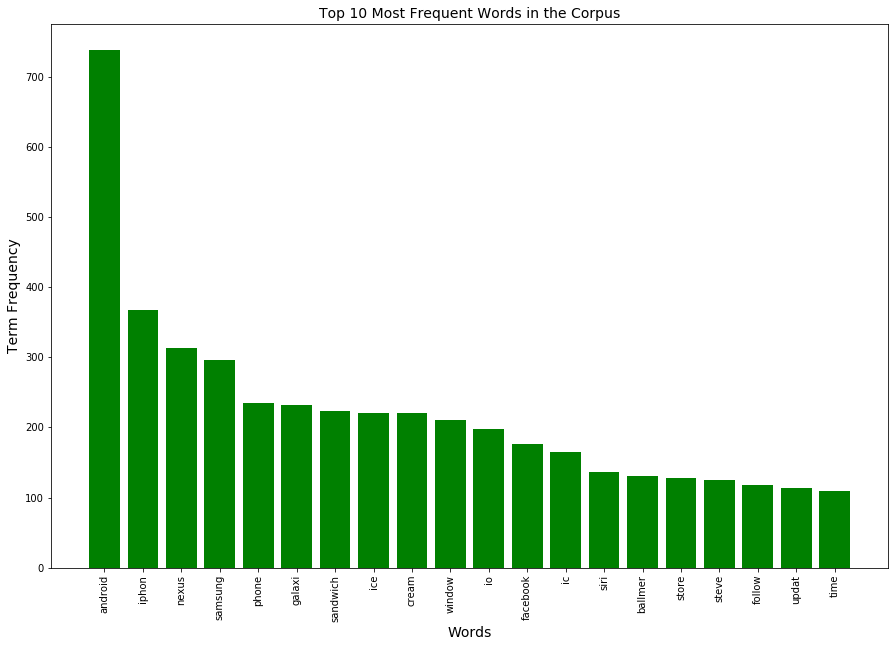

In [115]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(wc_20.index, wc_20[0], color='g')
plt.title("Top 10 Most Frequent Words in the Corpus", fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Term Frequency', fontsize=14)
plt.savefig('media/tf.png')
plt.xticks(rotation=90)

In [116]:
#create dictionary
id2word = gensim.corpora.Dictionary(processed_docs)

#create corpus
texts = processed_docs

#Term Document Frequency
bow_corpus = [id2word.doc2bow(text) for text in texts]

In [117]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in bow_corpus]

[[('crack', 1), ('iphon', 2), ('swype', 1)],
 [('iphon', 1), ('add', 1), ('announc', 1), ('carrier', 1), ('support', 1)],
 [('affair', 1),
  ('duet', 1),
  ('exbnqji', 1),
  ('guy', 1),
  ('hilari', 1),
  ('love', 1),
  ('pretti', 1),
  ('siri', 1),
  ('sum', 1),
  ('video', 1),
  ('youtub', 1)],
 [('iphon', 1), ('easi', 1), ('rim', 1), ('switch', 1)],
 [('get', 1), ('io', 1), ('realiz', 1), ('reason', 1), ('thank', 1)],
 [('iphon', 1),
  ('android', 1),
  ('bite', 1),
  ('blackberri', 1),
  ('current', 1),
  ('disappoint', 1),
  ('littl', 1),
  ('user', 1)],
 [('siri', 2),
  ('far', 1),
  ('give', 1),
  ('glad', 1),
  ('happyplac', 1),
  ('humor', 1),
  ('say', 1),
  ('sens', 1),
  ('sooo', 1),
  ('strangest', 1),
  ('thing', 1),
  ('twaeudbp', 1)],
 [('close', 1),
  ('event', 1),
  ('great', 1),
  ('person', 1),
  ('regent', 1),
  ('st', 1),
  ('store', 1),
  ('tonight', 1)],
 [('asid', 1),
  ('best', 1),
  ('compani', 1),
  ('custom', 1),
  ('experi', 1),
  ('servic', 1),
  ('zappo'

In [121]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=2, 
                                       id2word=id2word, 
                                       offset=2, 
                                       passes=20, 
                                       workers=2, 
                                       decay=0.5,
                                       gamma_threshold=2)

In [122]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.018*"android" + 0.008*"follow" + 0.007*"nexus" + 0.007*"samsung" + '
  '0.005*"galaxi" + 0.005*"sandwich" + 0.005*"cream" + 0.005*"ice" + '
  '0.005*"facebook" + 0.004*"io"'),
 (1,
  '0.006*"iphon" + 0.005*"facebook" + 0.004*"mi" + 0.004*"get" + 0.004*"need" '
  '+ 0.003*"day" + 0.003*"siri" + 0.003*"lol" + 0.003*"tweet" + 0.003*"free"')]


In [120]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.198209205838852

Coherence Score:  0.48749894443202485


In [41]:
doc_array

array([list(['swype', 'iphon', 'crack', 'iphon']),
       list(['add', 'carrier', 'support', 'iphon', 'announc']),
       list(['hilari', 'youtub', 'video', 'guy', 'duet', 'siri', 'pretti', 'sum', 'love', 'affair', 'exbnqji']),
       ...,
       list(['tien', 'mala', 'costumbr', 'ponerc', 'bno', 'cuano', 'yo', 'voy']),
       list(['oi', 'flaviasansi', 'muito', 'bem', 'vinda', 'ao', 'meu', 'sempr', 'dou', 'followback', 'pelo', 'meu', 'perfil', 'profission', 'permaneca', 'por', 'aqui', 'certo', 'abrass']),
       list(['ele', 'arrastaram', 'os', 'barco', 'para', 'praia', 'deixaram', 'tudo', 'seguiram', 'jesus', 'luca', 'est', 'foii', 'primeiro', 'da', 'historia', 'humana'])],
      dtype=object)

## Coherence Plot

In [36]:
def create_id2word(data):
    '''
    '''
    return corpora.Dictionary(data)


def create_corpus(id2word, data):
    '''
    '''
    return [id2word.doc2bow(text) for text in data]


def compute_coherence_values(texts, start=2, stop=30, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with
                       respective number of topics
    """
    coherence_values = []
    model_list = []

    id2word = create_id2word(texts)
    corpus = create_corpus(id2word, texts)

    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=id2word, passes=5, workers=2)
#         model = gensim.models.wrappers.LdaMallet(mallet_path,
#                                                  corpus=corpus,
#                                                  num_topics=num_topics,
#                                                  id2word=id2word)
        model_list.append((num_topics, model))
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=id2word,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, id2word, corpus

Calculating 2-topic model
Calculating 5-topic model
Calculating 8-topic model
Calculating 11-topic model
Calculating 14-topic model
Calculating 17-topic model
Calculating 20-topic model
Calculating 23-topic model
Calculating 26-topic model
Calculating 29-topic model


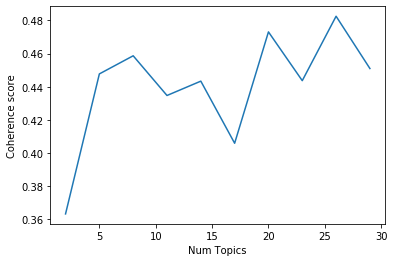

In [40]:
start=2
stop=30
step=3
stop += 1
(model_list,
 coherence_values,
 id2word,
 corpus) = compute_coherence_values(texts=doc_array,
                                            start=start,
                                            stop=stop,
                                            step=step)

# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
bow_corpus

[[(0, 1), (1, 2), (2, 1)],
 [(1, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1)],
 [(1, 1), (18, 1), (19, 1), (20, 1), (21, 1)],
 [(22, 1), (23, 1), (24, 1), (25, 1), (26, 1)],
 [(1, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)],
 [(14, 2),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1)],
 [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)],
 [(53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1)],
 [(60, 1), (61, 1), (62, 1), (63, 1)],
 [(14, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1)],
 [(14, 1),
  (64, 1),
  (65, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1)],
 [(47, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1)],
 [(47, 2),
  (50, 1),
  (82, 2),

## Making Bigrams

In [45]:
def make_bigrams(texts):
    '''
    '''
    data_words = texts
    # higher threshold fewer phrases.
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

In [50]:
# doc_array
bigram = make_bigrams(doc_array)
bigram

[['swype', 'iphon', 'crack', 'iphon'],
 ['add', 'carrier', 'support', 'iphon', 'announc'],
 ['hilari',
  'youtub',
  'video',
  'guy',
  'duet',
  'siri',
  'pretti',
  'sum',
  'love',
  'affair',
  'exbnqji'],
 ['rim', 'easi', 'switch', 'iphon', 'ya'],
 ['realiz', 'reason', 'get', 'io', 'thank'],
 ['current',
  'blackberri',
  'user',
  'littl',
  'bite',
  'disappoint',
  'android',
  'iphon'],
 ['strangest',
  'thing',
  'siri',
  'say',
  'far',
  'sooo',
  'glad',
  'give',
  'siri',
  'sens',
  'humor',
  'twaeudbp',
  'happyplac'],
 ['great', 'close', 'person', 'event', 'tonight', 'regent', 'st', 'store'],
 ['compani', 'experi', 'best', 'custom_servic', 'asid', 'zappo'],
 ['appli', 'job', 'hope', 'lol'],
 ['jamaicanidl',
  'lmao',
  'think',
  'magic',
  'die',
  'haha',
  'siri',
  'suggest',
  'whore'],
 ['lmao',
  'think',
  'magic',
  'die',
  'haha',
  'siri',
  'suggest',
  'whore',
  'hide',
  'bodi',
  'lolol'],
 ['philliprowntre',
  'regist',
  'develop',
  'hop',
  'a

In [142]:
doc_tops = lda_model.get_document_topics(bow_corpus)
doc_dist = []
doc_loads = []
for doc_top in doc_tops:
    doc_dist.append([tup[1] for tup in doc_top])
    doc_loads.append([tup[0] for tup in doc_top])
doc_dist

[[0.05059773, 0.051847074, 0.8473653, 0.05018987],
 [0.042583164, 0.04339477, 0.87165123, 0.042370837],
 [0.021884864, 0.021899238, 0.9351619, 0.021053953],
 [0.41839233, 0.49538106, 0.04276135, 0.04346523],
 [0.661169, 0.043906357, 0.25274715, 0.042177532],
 [0.16012953, 0.029249288, 0.78262806, 0.027993053],
 [0.018005228, 0.019033087, 0.63599885, 0.3269629],
 [0.02853202, 0.02980296, 0.91328716, 0.02837791],
 [0.031913534, 0.542472, 0.39394477, 0.031669647],
 [0.41180003, 0.052803207, 0.48320678, 0.052189987],
 [0.2966435, 0.6470431, 0.026430612, 0.02988283],
 [0.20385131, 0.59498644, 0.17942233, 0.021739937],
 [0.9133477, 0.028930916, 0.029542094, 0.028179238],
 [0.09696245, 0.8703044, 0.016701316, 0.016031817],
 [0.9018977, 0.03275262, 0.03360331, 0.031746347],
 [0.016185727, 0.016634846, 0.95114124, 0.01603816],
 [0.022702612, 0.79627347, 0.15797351, 0.02305041],
 [0.025805024, 0.9230149, 0.025788626, 0.025391506],
 [0.033323675, 0.032110088, 0.9014639, 0.03310232],
 [0.019018702

In [134]:
topic_of_doc = []
for doc in doc_dist:
    topic_of_doc.append(np.argmax(doc))
topic_of_doc

[2,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 0,
 2,
 1,
 3,
 0,
 3,
 2,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 3,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 3,
 2,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 3,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 3,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 0,
 3,
 0,
 0,
 1,
 0,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,


In [137]:
print(processed_docs[40])
print(topic_of_doc[40])

['download', 'io', 'prove', 'popular', 'user', 'nshlfiux']
2


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word, mds='mmds')
pyLDAvis.save_html(vis, 'media/LDA_4_topics.html')

/home/jarid/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## KMeans Clustering

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [142]:
documents = twitter['TweetText'].values
documents = list(documents)
documents

['Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is',
 '@Apple will be adding more carrier support to the iPhone 4S (just announced)',
 "Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY",
 '@RIM you made it too easy for me to switch to @Apple iPhone. See ya!',
 'I just realized that the reason I got into twitter was ios5 thanks @apple',
 "I'm a current @Blackberry user, little bit disappointed with it! Should I move to @Android or @Apple @iphone",
 'The 16 strangest things Siri has said so far. I am SOOO glad that @Apple gave Siri a sense of humor! http://t.co/TWAeUDBp via @HappyPlace',
 'Great up close & personal event @Apple tonight in Regent St store!',
 'From which companies do you experience the best customer service aside from @zappos and @apple?',
 'Just apply for a job at @Apple, hope they call me lol',
 'RT @JamaicanIdler: Lmao I think @apple is onto something magica

In [143]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)
X = X.toarray()

In [144]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [145]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 twitter
 rt
 facebook
 que
 en
 el
 http
 la
 es
 goodnight
Cluster 1:
 android
 google
 nexus
 sandwich
 cream
 ice
 samsung
 galaxy
 http
 ics
Cluster 2:
 apple
 iphone
 siri
 http
 ios5
 store
 4s
 new
 ios
 iphone4s
Cluster 3:
 microsoft
 http
 google
 rt
 windows
 android
 ballmer
 yahoo
 en
 nexusprime


In [146]:
Y = vectorizer.transform(["chrome is my go to browser."])
prediction = model.predict(Y)
print(prediction)

[3]


In [147]:
Y = vectorizer.transform(["I love my iphone."])
prediction = model.predict(Y)
print(prediction)

[2]


In [150]:
Y = vectorizer.transform(["I prefer to use android"])
prediction = model.predict(Y)
print(prediction)

[3]


In [149]:
Y = vectorizer.transform(["I think Google is the best"])
prediction = model.predict(Y)
print(prediction)

[3]


# Gensim Examples

In [51]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

dataset = api.load("text8")
dct = Dictionary(dataset)  # fit dictionary
corpus = [dct.doc2bow(line) for line in dataset]  # convert corpus to BoW format

model = TfidfModel(corpus)  # fit model
vector = model[corpus[0]]  # apply model to the first corpus document

[==================================================] 100.0% 31.6/31.6MB downloaded


In [52]:
dataset

In [53]:
dct

In [54]:
vector

[(1, 0.006704047545684609),
 (2, 0.0030255603220721273),
 (3, 0.003156168449586299),
 (4, 0.0036673470201144674),
 (5, 0.004575122435127926),
 (6, 0.0028052608258295926),
 (7, 0.004064820137019515),
 (8, 0.00014963587508918375),
 (9, 0.0007492665180478759),
 (10, 0.004142807322609117),
 (11, 0.004149816941645728),
 (12, 0.0077498817493309525),
 (13, 0.00656024165742503),
 (14, 0.003891486499758776),
 (15, 0.005476877392392166),
 (16, 0.0018233938817994433),
 (17, 0.0032209070754237084),
 (18, 0.0017737283389229173),
 (19, 0.0023373507198140124),
 (20, 0.003725514968930464),
 (21, 0.00590342512385848),
 (22, 0.003072401062545206),
 (23, 0.0006668171096292247),
 (24, 0.0017594266221832493),
 (25, 0.004202080158963513),
 (26, 0.002967397324595724),
 (27, 0.004709756138185673),
 (28, 0.0014819657487289912),
 (29, 0.0031562459553171694),
 (30, 0.0031999829254611097),
 (31, 0.001215574949729317),
 (32, 0.003843126241898761),
 (33, 0.006499414537896336),
 (34, 0.004546489373863172),
 (35, 0.0